This Lab is based on AIF360 tutorials. If interested, you can find more tutorials and tools at https://github.com/Trusted-AI/AIF360 




## **Installations**

In [ ]:
# install the package
!pip install 'aif360[all]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 5.5 MB/s 
     |████████████████████████████████| 235 kB 59.4 MB/s 
     |████████████████████████████████| 275 kB 51.9 MB/s 
     |████████████████████████████████| 2.8 MB 48.1 MB/s 
     |████████████████████████████████| 1.4 MB 33.5 MB/s 
     |████████████████████████████████| 2.6 MB 29.1 MB/s 
     |████████████████████████████████| 3.3 MB 11.6 MB/s 
     |████████████████████████████████| 510 kB 46.0 MB/s 
     |████████████████████████████████| 69 kB 4.4 MB/s 
     |████████████████████████████████| 9.4 MB 10.2 MB/s 
     |████████████████████████████████| 1.6 MB 16.6 MB/s 
     |████████████████████████████████| 295 kB 48.4 MB/s 
     |████████████████████████████████| 965 kB 48.8 MB/s 
     |████████████████████████████████| 121 kB 51.8 MB/s 
     |████████████████████████████████| 83 kB 1.3 MB/s 
     |██████████████████████████████

In [ ]:
pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipympl 0.9.2 requires matplotlib<4,>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
# check the version of Python you are using
!python --version

Python 3.8.16


In [ ]:
# check your currnet location
!pwd

/content


In [ ]:
# go to the folder where aif360 stores data
!cd '/usr/local/lib/python3.8/dist-packages/aif360/data/raw'

In [ ]:
ls

sample_data/


**Please download the following files:**

Adult:

	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data 
	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names



and place them, as-is, in the folder:


	/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

Note, that uploaded files will be in the folder only during runtime

In [ ]:
cd '/usr/local/lib/python3.8/dist-packages/aif360/data/raw/adult'

/usr/local/lib/python3.8/dist-packages/aif360/data/raw/adult


In [ ]:
ls

README.md


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving adult.names to adult.names
Saving adult.test to adult.test
Saving adult.data to adult.data


In [ ]:
# check if the datasetst are uploaded
!ls

adult.data  adult.names  adult.test  README.md


## **Imports And Define Helper Functions**

In [ ]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# # Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# # LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer


from aif360.metrics import BinaryLabelDatasetMetric

from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult,load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

from IPython.display import Markdown, display

np.random.seed(1)

def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)


def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = metrics['disp_imp'][best_ind]
    print("Corresponding disparate impact value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))

from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

# functions for LIME predictor
def s_predict_fn(x):
    return model.predict_proba(lime_data.inverse_transform(x))


def show_explanation(ind):
    exp = explainer.explain_instance(s_test[ind], s_predict_fn, num_features=10)
    print("Actual label: " + str(test_dataset.labels[ind]))
    exp.as_pyplot_figure()
    plt.show()


## **About Adult Dataset**

Extraction was done by Barry Becker from the 1994 Census database.

A set of reasonably clean records was extracted using the following 

conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.

# Load data & create splits for 
# learning/validating/testing model

We will be using 'race' as a sensitive attribute

In [ ]:
#load the data set and indicate the sensitive attribute

AdultDataset = load_preproc_data_adult(['race'])

privileged_groups = [{'race': 1}] # White
unprivileged_groups = [{'race': 0}] # Black


(adult_train,
 adult_val,
 adult_test) = AdultDataset.split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = adult_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       adult_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     adult_train.privileged_protected_attributes[sens_ind]]

In [ ]:
describe(adult_train, adult_val, adult_test)

#### Training Dataset shape

(24421, 18)


#### Validation Dataset shape

(14652, 18)


#### Test Dataset shape

(9769, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


## **Calculate Disparity Metrics on Original Training Data**

In [ ]:
metric_adult_train = BinaryLabelDatasetMetric(
        adult_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_adult_train = MetricTextExplainer(metric_adult_train)

print(explainer_adult_train.disparate_impact())
print(explainer_adult_train.statistical_parity_difference())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.6283123847672883
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.09489212158688873


The data is inbalanced with respect to sensitive attribute. Disparate impact is smaller than 1 indicating bias and Statistical Parity Difference is negative indicating discimination for unprivileged value of the sensitive attribute.

## **Learning a Logistic Regression (LR) classifier on original data**




In [ ]:
# train the Logistic Regression classifier
dataset = adult_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_adult = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [ ]:
# testing on validation data set and finding the best threshold for accuracy 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=adult_val,
                   model=lr_orig_adult,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [ ]:
# Testing on the test dataset using the best threshold

lr_orig_metrics = test(dataset=adult_test,
                       model=lr_orig_adult,thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [ ]:
# Calculating metrics on test data
describe_metrics(lr_orig_metrics,thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.7474
Corresponding disparate impact value: 0.4325
Corresponding average odds difference value: -0.1878
Corresponding statistical parity difference value: -0.2323
Corresponding equal opportunity difference value: -0.2005


For all the fairness metrics displayed above, except Disparate Impact, the value should be close to '0' for fairness.

Disparate impact value should be close to '1'.


<BarContainer object of 5 artists>

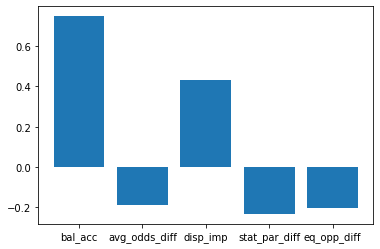

In [ ]:
# plotting the results

orig_results = [lr_orig_metrics['bal_acc'][0], lr_orig_metrics['avg_odds_diff'][0],lr_orig_metrics['disp_imp'][0], lr_orig_metrics['stat_par_diff'][0], lr_orig_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,orig_results)

## **Explaining with LIME**

In [ ]:
lime_data = LimeEncoder().fit(adult_train)

s_train = lime_data.transform(adult_train.features)
s_test = lime_data.transform(adult_test.features)

test_dataset = adult_test


explainer = LimeTabularExplainer(
        s_train, class_names=lime_data.s_class_names, 
        feature_names=lime_data.s_feature_names,
        categorical_features=lime_data.s_categorical_features, 
        categorical_names=lime_data.s_categorical_names, 
        kernel_width=3, verbose=False, discretize_continuous=True)

Actual label: [0.]


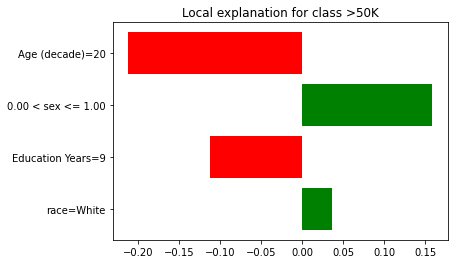

In [ ]:

show_explanation(0)

## **Bias mitigation using pre-processing technique - Reweighing**

In [ ]:
# transforming the dataset
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_adult_train = RW.fit_transform(adult_train)


#calculating metrics for transformed data

metric_transf_adult_train = BinaryLabelDatasetMetric(
        dataset_transf_adult_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_adult_train = MetricTextExplainer(metric_transf_adult_train)

print(explainer_transf_adult_train.disparate_impact())
print(explainer_transf_adult_train.statistical_parity_difference())



Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999999
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -2.7755575615628914e-17


## **Learning a Logistic Regression (LR) classifier on data transformed by reweighing**

In [ ]:
dataset = dataset_transf_adult_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_adult = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [ ]:
# testing on validation data set and finding the best threshold for accuracy 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=adult_val,
                   model=lr_transf_adult,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

In [ ]:
# testing on test dataset

lr_transf_metrics = test(dataset=adult_test,
                         model=lr_transf_adult,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [ ]:
# describe data

describe_metrics(lr_transf_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.7486
Corresponding disparate impact value: 0.7267
Corresponding average odds difference value: -0.0259
Corresponding statistical parity difference value: -0.1119
Corresponding equal opportunity difference value: 0.0195


<BarContainer object of 5 artists>

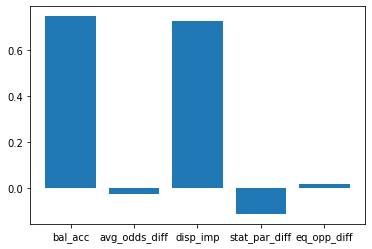

In [ ]:
# plotting the results 

transf_results = [lr_transf_metrics['bal_acc'][0], lr_transf_metrics['avg_odds_diff'][0],lr_transf_metrics['disp_imp'][0], lr_transf_metrics['stat_par_diff'][0], lr_transf_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,transf_results)

## **Explaining with LIME**

In [ ]:
lime_data = LimeEncoder().fit(dataset_transf_adult_train)

s_train = lime_data.transform(dataset_transf_adult_train.features)
s_test = lime_data.transform(adult_test.features)

test_dataset = adult_test

explainer = LimeTabularExplainer(
        s_train, class_names=lime_data.s_class_names, 
        feature_names=lime_data.s_feature_names,
        categorical_features=lime_data.s_categorical_features, 
        categorical_names=lime_data.s_categorical_names, 
        kernel_width=3, verbose=False, discretize_continuous=True)

Actual label: [0.]


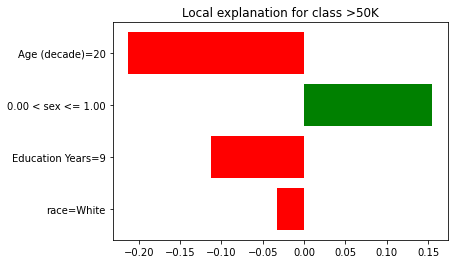

In [ ]:
show_explanation(0)

## **Bias mitigation using in-processing technique - Prejudice Remover (PR)**

In [ ]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = adult_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_adult = model.fit(dataset)

In [ ]:
# testing on validation data set and finding the best threshold for accuracy 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset,
                   model=pr_orig_adult,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [ ]:
# testing and cumputing metrics

dataset = adult_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_adult,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

In [ ]:
#describe metrics
describe_metrics(pr_orig_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.7465
Corresponding disparate impact value: 0.4239
Corresponding average odds difference value: -0.2009
Corresponding statistical parity difference value: -0.2465
Corresponding equal opportunity difference value: -0.2115


<BarContainer object of 5 artists>

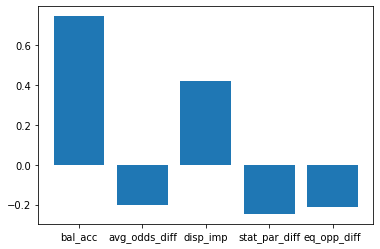

In [ ]:
# plotting the results 

pr_results = [pr_orig_metrics['bal_acc'][0], pr_orig_metrics['avg_odds_diff'][0],pr_orig_metrics['disp_imp'][0], pr_orig_metrics['stat_par_diff'][0], pr_orig_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,pr_results)

## **Summary of the Results**

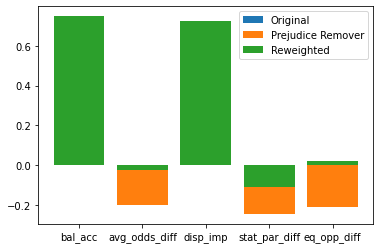

In [ ]:
orig_results = [lr_orig_metrics['bal_acc'][0], lr_orig_metrics['avg_odds_diff'][0],lr_orig_metrics['disp_imp'][0], lr_orig_metrics['stat_par_diff'][0], lr_orig_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,orig_results, label='Original')

pr_results = [pr_orig_metrics['bal_acc'][0], pr_orig_metrics['avg_odds_diff'][0],pr_orig_metrics['disp_imp'][0], pr_orig_metrics['stat_par_diff'][0], pr_orig_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,pr_results, label='Prejudice Remover')

transf_results = [lr_transf_metrics['bal_acc'][0], lr_transf_metrics['avg_odds_diff'][0],lr_transf_metrics['disp_imp'][0], lr_transf_metrics['stat_par_diff'][0], lr_transf_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,transf_results, label='Reweighted')

plt.legend()


In [ ]:
all_results = pd.DataFrame({'methods': ['original data',  'prejudice remover','reweighted data'],metric_names[0]:[orig_results[0],pr_results[0],transf_results[0]],metric_names[1]:[orig_results[1],pr_results[1],transf_results[1]],metric_names[2]:[orig_results[2],pr_results[2],transf_results[2]],metric_names[3]:[orig_results[3],pr_results[3],transf_results[3]], metric_names[4]:[orig_results[4],pr_results[4],transf_results[4]]})
all_results 


,methods,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff
0,original data,0.747430,-0.187828,0.432529,-0.232301,-0.200461
1,prejudice remover,0.746490,-0.200915,0.423870,-0.246510,-0.211453
2,reweighted data,0.748559,-0.025945,0.726718,-0.111871,0.019539


## **Exercise 1 (2 points): Select another (not 'race') sensitive attribute in the Adult dataset**

Perform same steps as in the examples but with different sensitive attribute. Have you noticed another sensitive attribute that is unfairly used for predictions (hint: take a look at LIME explanations)? Select it as 'sensitive attribute' when loading the adult dataset (the code is given below) and follow the steps to learn three types of classifiers: Logistic Regression on the original data, Logistic regression on the reweighted data and Prejudice Remover. Then compare the metrics and aswer the questions based on your observations.

In [ ]:
att = 'sex' #change to your attribute name

AdultDataset = load_preproc_data_adult([att])

privileged_groups = [{att: 1}] 
unprivileged_groups = [{att: 0}] 


(adult_train,
 adult_val,
 adult_test) = AdultDataset.split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = adult_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       adult_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     adult_train.privileged_protected_attributes[sens_ind]]


In [ ]:
describe(adult_train, adult_val, adult_test)

#### Training Dataset shape

(24421, 18)


#### Validation Dataset shape

(14652, 18)


#### Test Dataset shape

(9769, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [ ]:
metric_adult_train = BinaryLabelDatasetMetric(
        adult_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_adult_train = MetricTextExplainer(metric_adult_train)

print(explainer_adult_train.disparate_impact())
print(explainer_adult_train.statistical_parity_difference())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.3550364803159952
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.19482373391306854


##  **Exercise 2 (2 points)**: Learn a Logistic Regression Clasifier on the Original Data and Compute Fairness and Accuracy Metrics

In [ ]:
# train the Logistic Regression classifier
dataset = adult_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_adult = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [ ]:
# testing on validation data set and finding the best threshold for accuracy 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=adult_val,
                   model=lr_orig_adult,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [ ]:
# Testing on the test dataset using the best threshold

lr_orig_metrics = test(dataset=adult_test,
                       model=lr_orig_adult,thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [ ]:
# Calculating metrics on test data
describe_metrics(lr_orig_metrics,thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.7442
Corresponding disparate impact value: 0.2545
Corresponding average odds difference value: -0.3499
Corresponding statistical parity difference value: -0.4000
Corresponding equal opportunity difference value: -0.3939


##  **Exercise 3 (2 points)**: Learn a Logistic Regression Clasifier on the Reweighted Data and Compute Fairness and Accuracy Metrics

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.7461
Corresponding disparate impact value: 0.2850
Corresponding average odds difference value: -0.3216
Corresponding statistical parity difference value: -0.3791
Corresponding equal opportunity difference value: -0.3580


<BarContainer object of 5 artists>

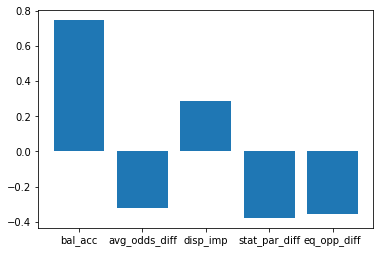

In [ ]:
# transform the dataset
dataset = dataset_transf_adult_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_adult = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)


#calculate metrics for transformed data
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=adult_val,
                   model=lr_transf_adult,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])


lr_transf_metrics = test(dataset=adult_test,
                         model=lr_transf_adult,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

# describe data
describe_metrics(lr_transf_metrics, thresh_arr)

# plotting the results 
transf_results = [lr_transf_metrics['bal_acc'][0], lr_transf_metrics['avg_odds_diff'][0],lr_transf_metrics['disp_imp'][0], lr_transf_metrics['stat_par_diff'][0], lr_transf_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,transf_results)



In [ ]:
# describe metrics

describe_metrics(lr_transf_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.7461
Corresponding disparate impact value: 0.2850
Corresponding average odds difference value: -0.3216
Corresponding statistical parity difference value: -0.3791
Corresponding equal opportunity difference value: -0.3580


##  **Exercise 4 (2 points)**: Learn a Prejudice Remover Clasifier on the *Original Data* and Compute Fairness and Accuracy Metrics

In [ ]:
# learn the model
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = adult_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_adult = model.fit(dataset)

In [ ]:
# testing on validation data set and finding the best threshold for accuracy 
# testing on validation data set and finding the best threshold for accuracy 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset,
                   model=pr_orig_adult,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [ ]:
# testing and cumputing metrics
# testing and cumputing metrics
dataset = adult_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_adult,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

In [ ]:
#describe metrics
describe_metrics(pr_orig_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.6922
Corresponding disparate impact value: 0.5993
Corresponding average odds difference value: -0.1042
Corresponding statistical parity difference value: -0.1532
Corresponding equal opportunity difference value: -0.1375


##  **Exercise 5 (2 points)**: Provide the Summary for All Three Classifiers 

In [ ]:
orig_results = [lr_orig_metrics['bal_acc'][0], lr_orig_metrics['avg_odds_diff'][0],lr_orig_metrics['disp_imp'][0], lr_orig_metrics['stat_par_diff'][0], lr_orig_metrics['eq_opp_diff'][0]]

pr_results = [pr_orig_metrics['bal_acc'][0], pr_orig_metrics['avg_odds_diff'][0],pr_orig_metrics['disp_imp'][0], pr_orig_metrics['stat_par_diff'][0], pr_orig_metrics['eq_opp_diff'][0]]

transf_results = [lr_transf_metrics['bal_acc'][0], lr_transf_metrics['avg_odds_diff'][0],lr_transf_metrics['disp_imp'][0], lr_transf_metrics['stat_par_diff'][0], lr_transf_metrics['eq_opp_diff'][0]]

metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]


In [ ]:
all_results = pd.DataFrame({'methods': ['original data',  'prejudice remover','reweighted data'],metric_names[0]:[orig_results[0],pr_results[0],transf_results[0]],metric_names[1]:[orig_results[1],pr_results[1],transf_results[1]],metric_names[2]:[orig_results[2],pr_results[2],transf_results[2]],metric_names[3]:[orig_results[3],pr_results[3],transf_results[3]], metric_names[4]:[orig_results[4],pr_results[4],transf_results[4]]})
all_results 

,methods,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff
0,original data,0.744153,-0.349853,0.254459,-0.399970,-0.393912
1,prejudice remover,0.692196,-0.104217,0.599329,-0.153235,-0.137452
2,reweighted data,0.746111,-0.321593,0.284995,-0.379129,-0.357990


## **Exercise 6 (2 points): Intersectionality**

Compute the Intersectional Statistical Parity for sensitive attribute combined from 'race' and yor chosen sensitive attribute. You can use the functions below.

In [ ]:
data = adult_train.convert_to_dataframe()[0]

#original sensitive attribute
race = 'race'
#your sensitive attribute. Replace text 'your sensitive attribute name' with the variable name.
att = 'sex'

In [ ]:
#calculate the probability for desirable income when both sensitive attributes are equal to zero (unprivileged)

value0 = data.loc[(data[race]==0)&(data[att]==0)&(data['Income Binary']==1)].shape[0]/data.loc[(data[race]==0)&(data[att]==0)].shape[0]

In [ ]:
#calculate the probability for desirable income when both sensitive attributes are equal to one (privileged)
value1=data.loc[(data[race]==1)&(data[att]==1)&(data['Income Binary']==1)].shape[0]/data.loc[(data[race]==1)&(data[att]==1)].shape[0]

In [ ]:
print("The Statistical Parity Difference for Intersectional Sensitive Attribute: ",value0-value1)

The Statistical Parity Difference for Intersectional Sensitive Attribute:  -0.24095636646881796


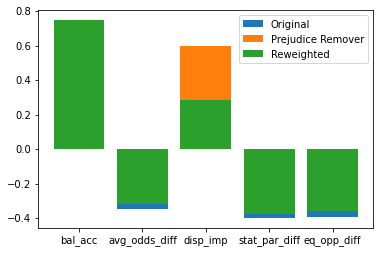

In [ ]:
orig_results = [lr_orig_metrics['bal_acc'][0], lr_orig_metrics['avg_odds_diff'][0],lr_orig_metrics['disp_imp'][0], lr_orig_metrics['stat_par_diff'][0], lr_orig_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,orig_results, label='Original')

pr_results = [pr_orig_metrics['bal_acc'][0], pr_orig_metrics['avg_odds_diff'][0],pr_orig_metrics['disp_imp'][0], pr_orig_metrics['stat_par_diff'][0], pr_orig_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,pr_results, label='Prejudice Remover')

transf_results = [lr_transf_metrics['bal_acc'][0], lr_transf_metrics['avg_odds_diff'][0],lr_transf_metrics['disp_imp'][0], lr_transf_metrics['stat_par_diff'][0], lr_transf_metrics['eq_opp_diff'][0]]
metric_names = ['bal_acc','avg_odds_diff',  'disp_imp',  'stat_par_diff',  'eq_opp_diff' ]
plt.bar(metric_names,transf_results, label='Reweighted')

plt.legend()

## **Questions**

**1. Which sensitive attribute did you choose? Towards which sensitive attribute was the data more unfair: the one in the example or the one you have used in the exercise? (2 points)**

I choosed sex attribute, as it the only sensitive attribute to choose, considering that age is not really a sensitive.


for race sensitive attribute:
Statistical parity difference: -0.095
Disparate impact: 0.6283

for sexe sensitive attribute
Statistical parity difference: -0.195
Disparate impact : 0.355

higher disparate impact is more likely to be considered discriminatory, thus race is a more snesitive attribute than sexe for salary. 
A negative statistical parity indicate in our context that our sensitive attribute suffer from discrimination compare to the priviledge group. In our context, the difference is bigger for sexe sensitive attribute. Therefore, the distribution of big salary is more inequal for sexe sensitive attribute.


**2. Which bias mitigation method performed better? (2 points)**

Prejudice remover performs better for the sexe sensitive attribute. However, reweighted bias mitigation was a most efficient choice for race sensitive attribute.


**3. What is the Statistical Parity difference for intersectional attribute? (2 points)**

The statistical parity difference for an intersectional attribute is the difference between probability of an outcome or decision for two different groups. Its means the distributions of data differs from 25%. 
A positive number shows that unpriviledge intersectional group of sexe and race have a batter probability of good outcome than priviledge group (that have both priviledge sexe and race attribute). This is a rather suprising result, it would be expected that being part of 2 sensitive group means less chance to get a 50k or more salary but results show otherwise.

**4. How disparity towards intersectional attribute compares to disparity for any of two sensitive attributes alone? (2 points)?**

The disparaty metric for intersectionnal attribute is considering the 2 people who are part of the 2 unpriviledge group, and those who are part of the 2 priviledge group. It compares the probability of good outcome between the 2.
This a comparaison by subtraction from the difference: for instance let's consider a white male as a priviledge intersectionnal group, and black women as unpriviledge intersectionnal group. The metrics mesures the difference in our case the probability to get an 50k or more salary between the 2.